In [1]:
 %matplotlib inline
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./KB_mxxg/comb_pre_to_cat2.csv')

In [3]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], 1)

In [4]:
def gucode(path):
    gucode = {}
    df = pd.read_csv(path, sep=':',names=['name', 'code'])
    for i,code in enumerate(df['code']):
        gucode[code] = df['name'][i]
    return gucode

gucode = gucode('./KB_mxxg/gucode.txt')

In [5]:
gucode

{11110: '종로구',
 11140: '중구',
 11170: '용산구',
 11200: '성동구',
 11215: '광진구',
 11230: '동대문구',
 11260: '중랑구',
 11290: '성북구',
 11305: '강북구',
 11320: '도봉구',
 11350: '노원구',
 11380: '은평구',
 11410: '서대문구',
 11440: '마포구',
 11470: '양천구',
 11500: '강서구',
 11530: '구로구',
 11545: '금천구',
 11560: '영등포구',
 11590: '동작구',
 11620: '관악구',
 11650: '서초구',
 11680: '강남구',
 11710: '송파구',
 11740: '강동구'}

In [6]:
def idx_custom(custom_data, year_range, year_idx, code):
    custom_data = custom_data.iloc[year_idx]
    custom_data = custom_data.reset_index(drop=True)
    print('Only {} data in {} year(s)'.format(gucode[code], year_range))
    print('Data size : {}'.format(len(custom_data)))
    
    return custom_data, gucode[code]

In [7]:
def custom_data(code):
    #input gu-code & year
    min_year = int(input('start year: '))
    max_year = int(input('end year: '))
    
    gu_idx = np.where(data[str(code)]==1)[0]
    
    custom_data = data.iloc[gu_idx] #원하는 구만 잘라냄
    custom_data = custom_data.reset_index(drop=True) #index 0부터 다시 초기화
    year_range = []
    
    if max_year >= min_year:
        
        for year in range(min_year, max_year + 1):
            year_range.append(year)
            
        tmp = [np.where(custom_data['d_yr'] == year)[0] for year in year_range]
        year_idx = np.concatenate(tmp)

        return idx_custom(custom_data, year_range, year_idx, code)
        
    elif max_year == min_year:
        year_range.append(min_year)
        year_idx = np.where(custom_data['d_yr'] == year_range[0])[0]
        
        return idx_custom(custom_data,year_range, year_idx, code)
    else:
        return 0
    

In [8]:
seocho, gu_name = custom_data(11650)

start year: 2010
end year: 2018
Only 서초구 data in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] year(s)
Data size : 10045


In [9]:
def datasplit(data):
    data = data.sample(frac=1).reset_index(drop=True) #shuffle
    data = data.reset_index(drop=True) #index 초기화
    
    train_len = int(len(data)*0.8)
    
    train = data.loc[:train_len-1]
    train = train.sample(frac=1).reset_index(drop=True) #shuffle
    train = train.reset_index(drop=True) #index 초기화
    
    test = data.loc[train_len:]
    test = test.sample(frac=1).reset_index(drop=True) #shuffle
    test = test.reset_index(drop=True)
    
    print ('{} data is splitted into {} train / {} test data'.format(len(data),len(train), len(test)))
    return train, test

In [11]:
train, test = datasplit(seocho)

10045 data is splitted into 8036 train / 2009 test data


In [12]:
def make_x_y(data):
    x = data.drop(['price', 'avg_price'],1)
    y = data['price'].values
    
    print('Done')
    return x,y

In [13]:
x_train, y_train = make_x_y(train)
x_test, y_test = make_x_y(test)

Done
Done


/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


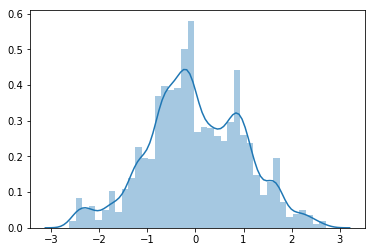

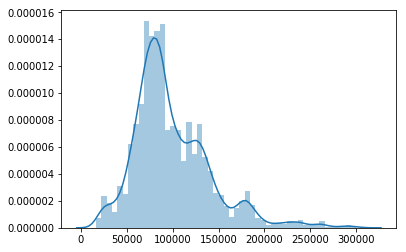

In [14]:
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y_train) #정규분포화
yt2 = johnson_inverse(yt, g, et, ep, l) #inverse 정규분포화
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers,optimizers,losses
from keras.layers.normalization import BatchNormalization

import datetime
import os

Using TensorFlow backend.


In [68]:
# path where all models are saved
now = datetime.datetime.now()
ymd = (str(now.year) + str(now.month) + str(now.day))

BASE_PATH = './'+gu_name+'_model_'+ymd+'/'
MODEL_NAME = 'MLP_rmse'
CURR_PATH = BASE_PATH + MODEL_NAME + "/"

if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50)

In [17]:
def custom_loss(y_true,y_pred):
    import keras.backend as K
    #loss = K.mean((y_true - y_pred)**2, axis=-1)
    loss = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''
    def _logcosh(x):
        return x + K.softplus(-2. * x) - K.log(2.)
    loss= K.mean(_logcosh(y_pred - y_true), axis=-1)
    '''
    return loss

In [18]:
def rmse(y_true,y_pred):
    import keras.backend as K
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [19]:
def rmsle(y_true, y_pred):
    import keras.backend as K
    first_log = K.log(y_pred + 1)
    second_log = K.log(y_true + 1)
    loss= K.sqrt(K.mean(K.square(first_log - second_log)))
    return loss

In [20]:
def rmsle_for_eval(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log(y_pred+1)-np.log(y_true+1))))

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
adam = optimizers.Adam(lr=0.0009, decay=0.0001)

In [23]:
def Model(x_train, y_train, batch_size, max_epochs):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=114))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=adam,
                  loss=rmse,
                  metrics=['accuracy'])

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    # Validation_split으로 validation 얼마나 해줄건지 정해중!
    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=max_epochs,
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[checkloss, early_stopping])
    
    return model, history

In [30]:
model = Model(x_train, yt, 16, 5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               14720     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
__________

7232/7232 [==============================] - 2s 245us/step - loss: 0.4809 - acc: 0.0000e+00 - val_loss: 0.5889 - val_acc: 0.0000e+00

Epoch 00031: val_loss did not improve from 0.54208
Epoch 32/5000
7232/7232 [==============================] - 2s 252us/step - loss: 0.4771 - acc: 0.0000e+00 - val_loss: 0.5223 - val_acc: 0.0000e+00

Epoch 00032: val_loss improved from 0.54208 to 0.52232, saving model to ./서초구_model_20181117/MLP_rmse/val_loss-0.522321.hdf5
Epoch 33/5000
7232/7232 [==============================] - 2s 255us/step - loss: 0.4709 - acc: 0.0000e+00 - val_loss: 0.5649 - val_acc: 0.0000e+00

Epoch 00033: val_loss did not improve from 0.52232
Epoch 34/5000
7232/7232 [==============================] - 2s 249us/step - loss: 0.4746 - acc: 0.0000e+00 - val_loss: 0.6037 - val_acc: 0.0000e+00

Epoch 00034: val_loss did not improve from 0.52232
Epoch 35/5000
7232/7232 [==============================] - 2s 241us/step - loss: 0.4746 - acc: 0.0000e+00 - val_loss: 0.6078 - val_acc: 0.0000e+

7232/7232 [==============================] - 2s 276us/step - loss: 0.4190 - acc: 0.0000e+00 - val_loss: 0.3546 - val_acc: 0.0000e+00

Epoch 00070: val_loss did not improve from 0.33819
Epoch 71/5000
7232/7232 [==============================] - 2s 256us/step - loss: 0.4193 - acc: 0.0000e+00 - val_loss: 0.3565 - val_acc: 0.0000e+00

Epoch 00071: val_loss did not improve from 0.33819
Epoch 72/5000
7232/7232 [==============================] - 2s 261us/step - loss: 0.4193 - acc: 0.0000e+00 - val_loss: 0.3449 - val_acc: 0.0000e+00

Epoch 00072: val_loss did not improve from 0.33819
Epoch 73/5000
7232/7232 [==============================] - 2s 260us/step - loss: 0.4048 - acc: 0.0000e+00 - val_loss: 0.3933 - val_acc: 0.0000e+00

Epoch 00073: val_loss did not improve from 0.33819
Epoch 74/5000
7232/7232 [==============================] - 2s 259us/step - loss: 0.4172 - acc: 0.0000e+00 - val_loss: 0.3761 - val_acc: 0.0000e+00

Epoch 00074: val_loss did not improve from 0.33819
Epoch 75/5000
7232/

7232/7232 [==============================] - 2s 254us/step - loss: 0.3791 - acc: 0.0000e+00 - val_loss: 0.3287 - val_acc: 0.0000e+00

Epoch 00110: val_loss did not improve from 0.29821
Epoch 111/5000
7232/7232 [==============================] - 2s 264us/step - loss: 0.3717 - acc: 0.0000e+00 - val_loss: 0.3101 - val_acc: 0.0000e+00

Epoch 00111: val_loss did not improve from 0.29821
Epoch 112/5000
7232/7232 [==============================] - 2s 252us/step - loss: 0.3716 - acc: 0.0000e+00 - val_loss: 0.3117 - val_acc: 0.0000e+00

Epoch 00112: val_loss did not improve from 0.29821
Epoch 113/5000
7232/7232 [==============================] - 2s 253us/step - loss: 0.3729 - acc: 0.0000e+00 - val_loss: 0.4109 - val_acc: 0.0000e+00

Epoch 00113: val_loss did not improve from 0.29821
Epoch 114/5000
7232/7232 [==============================] - 2s 255us/step - loss: 0.3740 - acc: 0.0000e+00 - val_loss: 0.2736 - val_acc: 0.0000e+00

Epoch 00114: val_loss improved from 0.29821 to 0.27357, saving mod

7232/7232 [==============================] - 2s 253us/step - loss: 0.3606 - acc: 0.0000e+00 - val_loss: 0.3141 - val_acc: 0.0000e+00

Epoch 00150: val_loss did not improve from 0.26623
Epoch 151/5000
7232/7232 [==============================] - 2s 254us/step - loss: 0.3660 - acc: 0.0000e+00 - val_loss: 0.3025 - val_acc: 0.0000e+00

Epoch 00151: val_loss did not improve from 0.26623
Epoch 152/5000
7232/7232 [==============================] - 2s 252us/step - loss: 0.3647 - acc: 0.0000e+00 - val_loss: 0.2962 - val_acc: 0.0000e+00

Epoch 00152: val_loss did not improve from 0.26623
Epoch 153/5000
7232/7232 [==============================] - 2s 263us/step - loss: 0.3638 - acc: 0.0000e+00 - val_loss: 0.2963 - val_acc: 0.0000e+00

Epoch 00153: val_loss did not improve from 0.26623
Epoch 154/5000
7232/7232 [==============================] - 2s 248us/step - loss: 0.3586 - acc: 0.0000e+00 - val_loss: 0.3318 - val_acc: 0.0000e+00

Epoch 00154: val_loss did not improve from 0.26623
Epoch 155/5000



Epoch 00190: val_loss did not improve from 0.26467
Epoch 191/5000
7232/7232 [==============================] - 2s 237us/step - loss: 0.3456 - acc: 0.0000e+00 - val_loss: 0.2925 - val_acc: 0.0000e+00

Epoch 00191: val_loss did not improve from 0.26467
Epoch 192/5000
7232/7232 [==============================] - 2s 245us/step - loss: 0.3533 - acc: 0.0000e+00 - val_loss: 0.2920 - val_acc: 0.0000e+00

Epoch 00192: val_loss did not improve from 0.26467
Epoch 193/5000
7232/7232 [==============================] - 2s 246us/step - loss: 0.3404 - acc: 0.0000e+00 - val_loss: 0.2991 - val_acc: 0.0000e+00

Epoch 00193: val_loss did not improve from 0.26467
Epoch 194/5000
7232/7232 [==============================] - 2s 238us/step - loss: 0.3468 - acc: 0.0000e+00 - val_loss: 0.2948 - val_acc: 0.0000e+00

Epoch 00194: val_loss did not improve from 0.26467
Epoch 195/5000
7232/7232 [==============================] - 2s 239us/step - loss: 0.3465 - acc: 0.0000e+00 - val_loss: 0.2911 - val_acc: 0.0000e+00


7232/7232 [==============================] - 2s 223us/step - loss: 0.3404 - acc: 0.0000e+00 - val_loss: 0.2423 - val_acc: 0.0000e+00

Epoch 00230: val_loss improved from 0.24623 to 0.24231, saving model to ./서초구_model_20181117/MLP_rmse/val_loss-0.242305.hdf5
Epoch 231/5000
7232/7232 [==============================] - 2s 226us/step - loss: 0.3397 - acc: 0.0000e+00 - val_loss: 0.2653 - val_acc: 0.0000e+00

Epoch 00231: val_loss did not improve from 0.24231
Epoch 232/5000
7232/7232 [==============================] - 2s 227us/step - loss: 0.3437 - acc: 0.0000e+00 - val_loss: 0.2477 - val_acc: 0.0000e+00

Epoch 00232: val_loss did not improve from 0.24231
Epoch 233/5000
7232/7232 [==============================] - 2s 225us/step - loss: 0.3460 - acc: 0.0000e+00 - val_loss: 0.2548 - val_acc: 0.0000e+00

Epoch 00233: val_loss did not improve from 0.24231
Epoch 234/5000
7232/7232 [==============================] - 2s 223us/step - loss: 0.3317 - acc: 0.0000e+00 - val_loss: 0.2685 - val_acc: 0.00

7232/7232 [==============================] - 2s 241us/step - loss: 0.3355 - acc: 0.0000e+00 - val_loss: 0.2622 - val_acc: 0.0000e+00

Epoch 00270: val_loss did not improve from 0.23819
Epoch 271/5000
7232/7232 [==============================] - 2s 242us/step - loss: 0.3366 - acc: 0.0000e+00 - val_loss: 0.3335 - val_acc: 0.0000e+00

Epoch 00271: val_loss did not improve from 0.23819
Epoch 272/5000
7232/7232 [==============================] - 2s 241us/step - loss: 0.3441 - acc: 0.0000e+00 - val_loss: 0.2505 - val_acc: 0.0000e+00

Epoch 00272: val_loss did not improve from 0.23819
Epoch 273/5000
7232/7232 [==============================] - 2s 237us/step - loss: 0.3400 - acc: 0.0000e+00 - val_loss: 0.2561 - val_acc: 0.0000e+00

Epoch 00273: val_loss did not improve from 0.23819
Epoch 274/5000
7232/7232 [==============================] - 2s 240us/step - loss: 0.3400 - acc: 0.0000e+00 - val_loss: 0.2381 - val_acc: 0.0000e+00

Epoch 00274: val_loss improved from 0.23819 to 0.23810, saving mod

7232/7232 [==============================] - 2s 235us/step - loss: 0.3308 - acc: 0.0000e+00 - val_loss: 0.2273 - val_acc: 0.0000e+00

Epoch 00310: val_loss improved from 0.23413 to 0.22729, saving model to ./서초구_model_20181117/MLP_rmse/val_loss-0.227289.hdf5
Epoch 311/5000
7232/7232 [==============================] - 2s 238us/step - loss: 0.3273 - acc: 0.0000e+00 - val_loss: 0.2756 - val_acc: 0.0000e+00

Epoch 00311: val_loss did not improve from 0.22729
Epoch 312/5000
7232/7232 [==============================] - 2s 248us/step - loss: 0.3258 - acc: 0.0000e+00 - val_loss: 0.2491 - val_acc: 0.0000e+00

Epoch 00312: val_loss did not improve from 0.22729
Epoch 313/5000
7232/7232 [==============================] - 2s 256us/step - loss: 0.3363 - acc: 0.0000e+00 - val_loss: 0.2614 - val_acc: 0.0000e+00

Epoch 00313: val_loss did not improve from 0.22729
Epoch 314/5000
7232/7232 [==============================] - 2s 242us/step - loss: 0.3341 - acc: 0.0000e+00 - val_loss: 0.2648 - val_acc: 0.00


Epoch 00350: val_loss did not improve from 0.22729
Epoch 351/5000
7232/7232 [==============================] - 2s 273us/step - loss: 0.3283 - acc: 0.0000e+00 - val_loss: 0.2390 - val_acc: 0.0000e+00

Epoch 00351: val_loss did not improve from 0.22729
Epoch 352/5000
7232/7232 [==============================] - 2s 268us/step - loss: 0.3342 - acc: 0.0000e+00 - val_loss: 0.3060 - val_acc: 0.0000e+00

Epoch 00352: val_loss did not improve from 0.22729
Epoch 353/5000
7232/7232 [==============================] - 2s 256us/step - loss: 0.3263 - acc: 0.0000e+00 - val_loss: 0.2522 - val_acc: 0.0000e+00

Epoch 00353: val_loss did not improve from 0.22729
Epoch 354/5000
7232/7232 [==============================] - 2s 251us/step - loss: 0.3313 - acc: 0.0000e+00 - val_loss: 0.2721 - val_acc: 0.0000e+00

Epoch 00354: val_loss did not improve from 0.22729
Epoch 355/5000
7232/7232 [==============================] - 2s 263us/step - loss: 0.3255 - acc: 0.0000e+00 - val_loss: 0.2399 - val_acc: 0.0000e+00


In [58]:
def plot_train(history):
    fig, loss_ax = plt.subplots(figsize=(10,10))

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')


    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')

    loss_ax.legend(loc='upper right')

    plt.show()
    
def test_summary(model, weight_path):
    plot_train(model[1]) #history = moedl[1]
    model[0].load_weights(weight_path) #model = model[0]
    norm_y = g + et*np.arcsinh((y_test-ep)/l)
    loss, acc = model[0].evaluate(x_test, norm_y, batch_size=32)
    #loss, acc = model[0].evaluate(x_test, y_test, batch_size=32)
    print('----- Evaluation loss and metrics -----')
    print('Test loss - RMSE : {:.5f}'.format(loss))
    
    
def save_model(model, path, gu_name):
    model_json = model[0].to_json()
    
    file_name = path+gu_name+'_model.json'
    print(file_name)
    with open(file_name, "w") as json_file : 
        json_file.write(model_json)
        
def load_model(path, gu_name):
    from keras.models import model_from_json
    
    file_name = path+gu_name+'_model.json'
    
    json_file = open(file_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    return loaded_model

In [73]:
def get_best_weights_path():
    return CURR_PATH + sorted(os.listdir(CURR_PATH))[0]

In [74]:
FULL_PATH = get_best_weights_path()
print(FULL_PATH)

./서초구_model_20181117/MLP_rmse/val_loss-0.220076.hdf5


In [57]:
save_model(model, CURR_PATH, gu_name)

./서초구_model_20181117/MLP_rmse/서초구_model.json


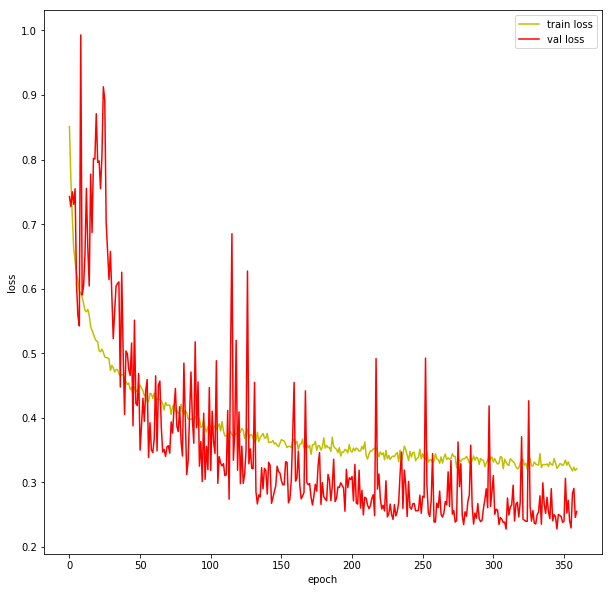

2009/2009 [==============================] - 0s 33us/step
----- Evaluation loss and metrics -----
Test loss - RMSE : 0.22212


In [34]:
test_summary(model,FULL_PATH)

In [35]:
def prediction_plot(n_sample):
    from sklearn.metrics import r2_score

    randidx = np.random.choice(len(x_test), n_sample, replace=False)
  
    
    y_pred = model[0].predict(x_test).flatten()
    y_pred = johnson_inverse(y_pred, g, et, ep, l)
    
    _y_pred = y_pred[randidx]
    y_sample = y_test[randidx]

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

    index = np.arange(n_sample)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax0.bar(index, y_sample, bar_width, alpha=opacity, color='b',label='GT')
    rects2 = ax0.bar(index + bar_width, _y_pred, bar_width, alpha=opacity, color='r',label='Pred')

    ax0.set_xlabel('Data')
    ax0.set_ylabel('Price')
    ax0.set_title('Difference between GT/Pred - {}'.format(gu_name))
    ax0.legend()

    
    loss = rmsle_for_eval(y_test, y_pred)

    lower_bound = int(y_test.min())-10000
    higher_bound = int(y_test.max())+10000
    
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    
    ax1.scatter(y_test, y_pred, alpha=opacity, color='g')
    ax1.plot([lower_bound, higher_bound], [lower_bound, higher_bound], '--k')
    ax1.set_ylabel('Pred')
    ax1.set_xlabel('GT')
    ax1.set_title('Regression - {}'.format(gu_name))
    ax1.text(lower_bound+25000, lower_bound+15000, r'$R^2$={:.2f}, RMSLE={:.5f}'.format(r2_score(y_test, y_pred),loss))
    ax1.set_xlim([lower_bound, higher_bound])
    ax1.set_ylim([lower_bound, higher_bound])
    
    fig.tight_layout()
    plt.show()
    
    diff = abs(y_pred-y_test)
    print('Max difference : {:.2f} 만원'.format(diff.max()))
    print('Mean difference : {:.2f} 만원'.format(diff.mean()))
    print('--------')
    print('Avg Price of {}: {:.2f} 만원'.format(gu_name,y_test.mean()))
    print('--------')
    print('R2 Coefficient : {:.3f}'.format(r2_score(y_test, y_pred)))
    print('RMLSE loss : {:.4f}'.format(loss))
    print('MAPE : {:.4f}' .format(mape))
    return y_pred, diff

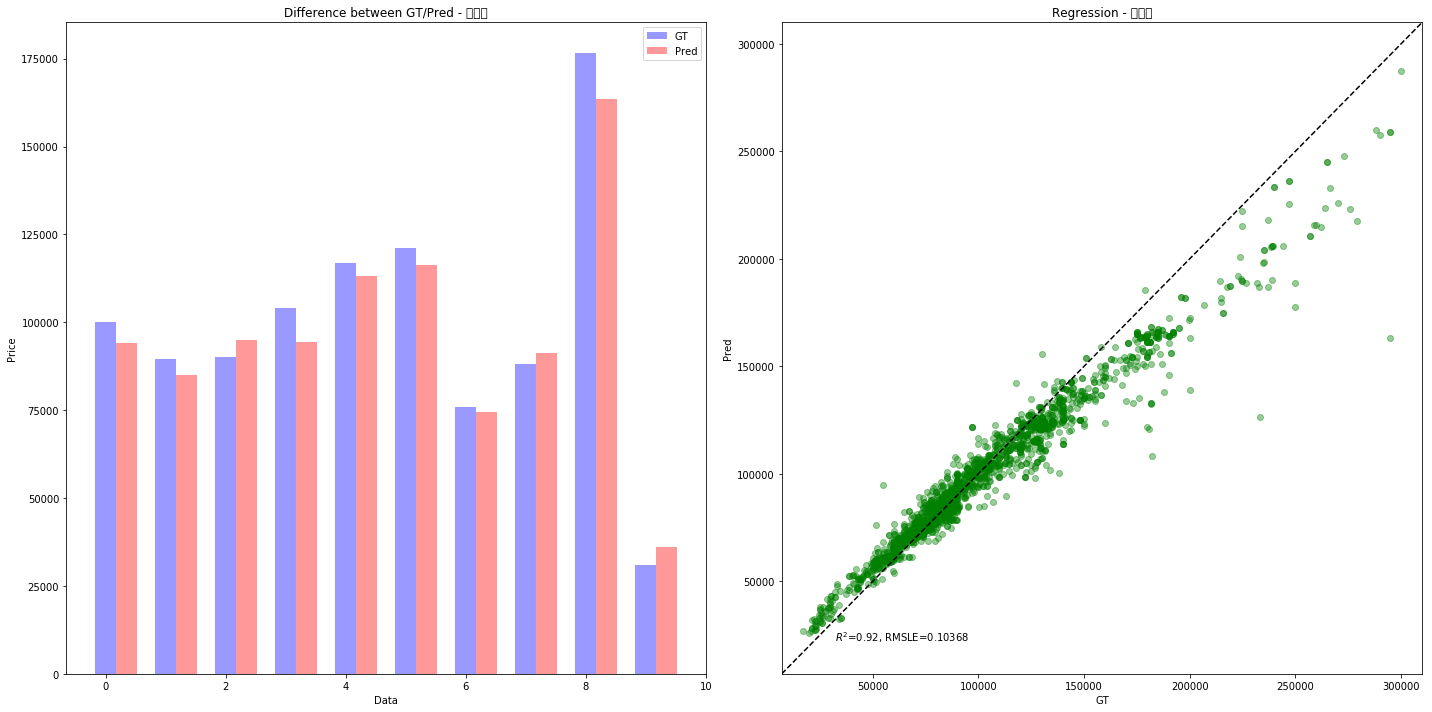

Max difference : 131988.42 만원
Mean difference : 7795.46 만원
--------
Avg Price of 서초구: 101535.96 만원
--------
R2 Coefficient : 0.924
RMLSE loss : 0.1037
MAPE : 7.6653


In [36]:
y_pred, diff = prediction_plot(10)

In [60]:
def run_loaded_model(model, x_train, y_train, batch_size, max_epochs):
    model.compile(optimizer=adam,
                  loss=rmse,
                  metrics=['accuracy'])
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=max_epochs,
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[checkloss, early_stopping])
    
    return model, history

In [75]:
loaded_model = load_model(CURR_PATH, gu_name)
FULL_PATH = get_best_weights_path()
loaded_model.load_weights(FULL_PATH)

In [76]:
model = run_loaded_model(loaded_model, x_train, yt, 16, 5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               14720     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
__________

7232/7232 [==============================] - 2s 249us/step - loss: 0.3019 - acc: 0.0000e+00 - val_loss: 0.2850 - val_acc: 0.0000e+00

Epoch 00030: val_loss did not improve from 0.21896
Epoch 31/5000
7232/7232 [==============================] - 2s 240us/step - loss: 0.3114 - acc: 0.0000e+00 - val_loss: 0.2353 - val_acc: 0.0000e+00

Epoch 00031: val_loss did not improve from 0.21896
Epoch 32/5000
7232/7232 [==============================] - 2s 243us/step - loss: 0.3273 - acc: 0.0000e+00 - val_loss: 0.2649 - val_acc: 0.0000e+00

Epoch 00032: val_loss did not improve from 0.21896
Epoch 33/5000
7232/7232 [==============================] - 2s 244us/step - loss: 0.3168 - acc: 0.0000e+00 - val_loss: 0.2339 - val_acc: 0.0000e+00

Epoch 00033: val_loss did not improve from 0.21896
Epoch 34/5000
7232/7232 [==============================] - 2s 239us/step - loss: 0.3285 - acc: 0.0000e+00 - val_loss: 0.2334 - val_acc: 0.0000e+00

Epoch 00034: val_loss did not improve from 0.21896
Epoch 35/5000
7232/

7232/7232 [==============================] - 2s 266us/step - loss: 0.3237 - acc: 0.0000e+00 - val_loss: 0.2542 - val_acc: 0.0000e+00

Epoch 00071: val_loss did not improve from 0.21896
Epoch 72/5000
7232/7232 [==============================] - 2s 269us/step - loss: 0.3200 - acc: 0.0000e+00 - val_loss: 0.3406 - val_acc: 0.0000e+00

Epoch 00072: val_loss did not improve from 0.21896
Epoch 73/5000
7232/7232 [==============================] - 2s 261us/step - loss: 0.3166 - acc: 0.0000e+00 - val_loss: 0.2273 - val_acc: 0.0000e+00

Epoch 00073: val_loss did not improve from 0.21896
Epoch 74/5000
7232/7232 [==============================] - 2s 259us/step - loss: 0.3218 - acc: 0.0000e+00 - val_loss: 0.2254 - val_acc: 0.0000e+00

Epoch 00074: val_loss did not improve from 0.21896
Epoch 75/5000
7232/7232 [==============================] - 2s 270us/step - loss: 0.3151 - acc: 0.0000e+00 - val_loss: 0.2375 - val_acc: 0.0000e+00

Epoch 00075: val_loss did not improve from 0.21896
Epoch 76/5000
7232/

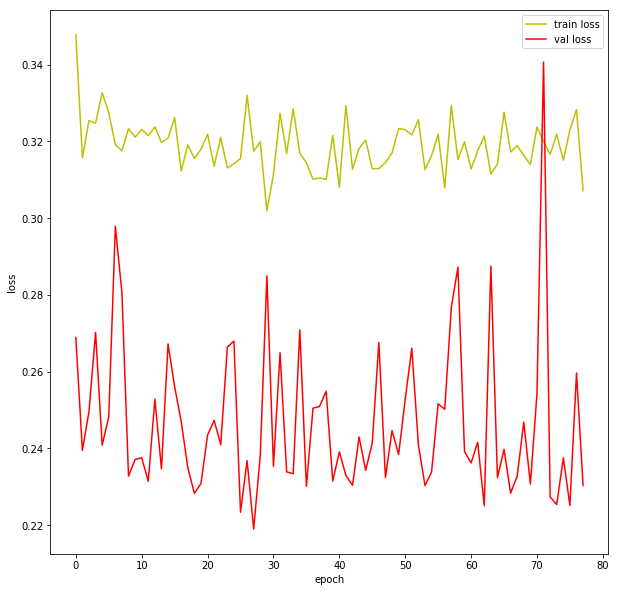

2009/2009 [==============================] - 0s 53us/step
----- Evaluation loss and metrics -----
Test loss - RMSE : 0.22035


In [78]:
test_summary(model,FULL_PATH)

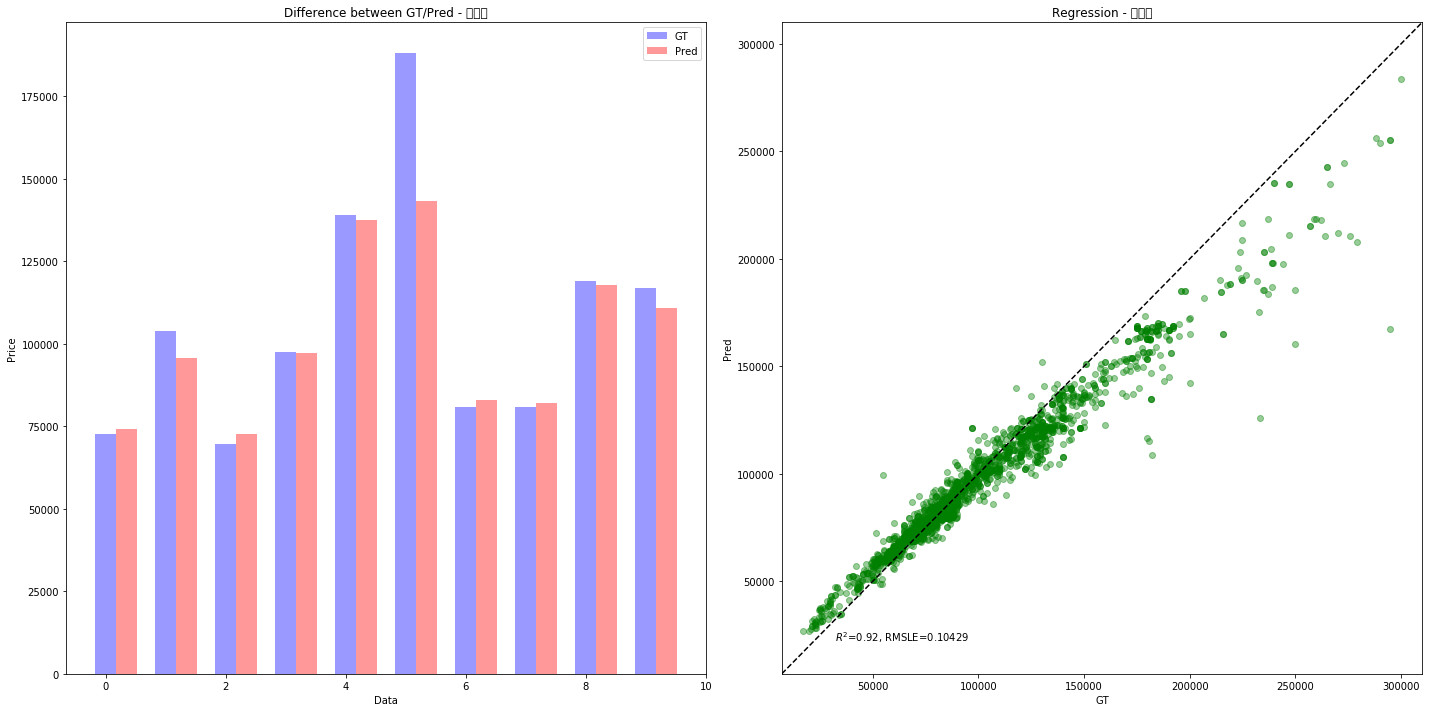

Max difference : 127477.34 만원
Mean difference : 7833.14 만원
--------
Avg Price of 서초구: 101535.96 만원
--------
R2 Coefficient : 0.919
RMLSE loss : 0.1043
MAPE : 7.5310


In [82]:
y_pred, diff = prediction_plot(10)